# Analysis of 10x Visium spatial transcriptomics

This tutorial demonstrates how to analyze 10x Visium spatial transcriptomics data using LANTSA including

* Clustering & visualization
* Cell type annotation
* Cell type marker genes

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import lantsa

## Read the data

Firstly, we use [scanpy.read_visium()](https://scanpy.readthedocs.io/en/latest/api/scanpy.read_visium.html) to read 10x Visium *Mouse Brain Serial Section 1 (Sagittal-Anterior)* dataset, which is publicly available from the 10x genomics website: [link](https://support.10xgenomics.com/spatial-gene-expression/datasets/1.0.0/V1_Mouse_Brain_Sagittal_Anterior).

In [2]:
adata = sc.read_visium('./data/Sagittal_Anterior/')
adata.var_names_make_unique()
adata

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 2696 × 31053
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

## Preprocessing

Then, we perform basic preprocessing including finding highly variable genes and log transformation.

In [3]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor='seurat_v3')
sc.pp.log1p(adata)

## Landmark-based subspace analysis

Now, we select landmark samples and then use selected landmarks to learn subspace representation.

In [4]:
lantsa.select_landmarks(adata, n_landmarks=1000)

 84%|████████████████████████████████████████████▎        | 1670/2000 [00:42<00:08, 39.67it/s, seleted landmarks: 1000]


In [5]:
lantsa.subspace_analysis(adata, Lambda=0.1, n_neighbors=200)

 21%|██████▍                       | 107/500 [00:04<00:16, 23.63it/s, relChg: 2.715e-05, recErr: 9.936e-06, converged!]


This is how the `adata` looks like after landmark-based subspace analysis.

In [6]:
adata

AnnData object with n_obs × n_vars = 2696 × 31053
    obs: 'in_tissue', 'array_row', 'array_col', 'is_landmark'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'spatial', 'hvg', 'log1p', 'select_landmarks', 'subspace_analysis'
    obsm: 'spatial'
    varm: 'discriminant'
    obsp: 'representation'

## Clustering and visualization

The resulting `adata` is compatible with [scanpy.tl.leiden()](https://scanpy.readthedocs.io/en/stable/generated/scanpy.tl.leiden.html) for clustering and [scanpy.tl.umap()](https://scanpy.readthedocs.io/en/stable/generated/scanpy.tl.umap.html) for visualization.

In [7]:
sc.tl.leiden(adata, resolution=2.6, neighbors_key='subspace_analysis')

In [8]:
sc.pp.pca(adata)
sc.tl.umap(adata, init_pos='random', neighbors_key='subspace_analysis')

We visualize the inferred clusters in UMAP space.

... storing 'feature_types' as categorical
... storing 'genome' as categorical


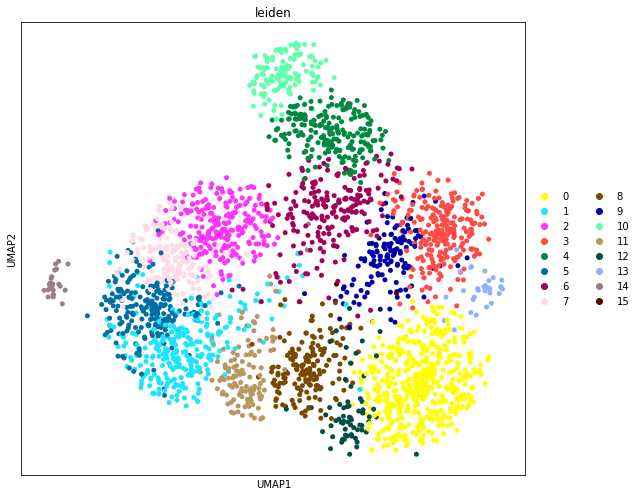

In [9]:
fig, axs = plt.subplots(figsize=(9, 7))

sc.pl.umap(
    adata,
    color="leiden",
    size=100,
    palette=sc.pl.palettes.default_102,
    legend_loc='right margin',
    show=False,
    ax=axs,
)

plt.tight_layout()

We also visualize the inferred clusters in spatial coordinates.

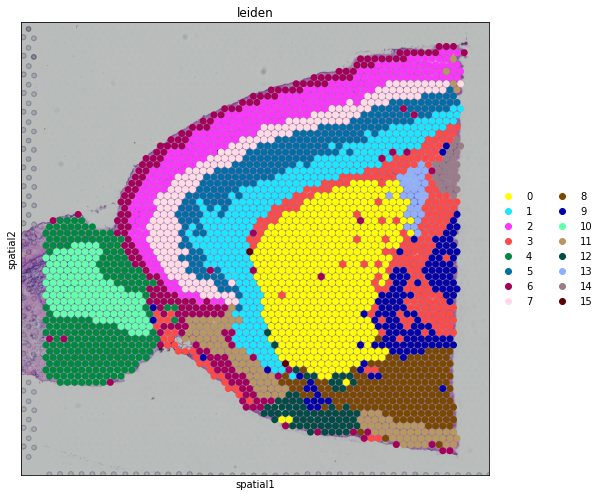

In [10]:
fig, axs = plt.subplots(figsize=(9, 7))

sc.pl.spatial(
    adata,
    img_key="hires",
    color="leiden",
    size=1.5,
    palette=sc.pl.palettes.default_102,
    legend_loc='right margin',
    show=False,
    ax=axs,
)

plt.tight_layout()

## Cell type annotation
After clustering, we compute the differentially expressed (DE) genes of each cluster for annotation.

In [11]:
sc.tl.rank_genes_groups(adata, groupby='leiden', method='t-test')

In [12]:
marker_genes = pd.DataFrame(adata.uns['rank_genes_groups']['names']).iloc[:10,:]
marker_genes

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,Ppp1r1b,3110035E14Rik,Camk2n1,Plp1,Calb2,1110008P14Rik,Ptgds,Stx1a,Zcchc12,Mobp,Gng4,Nptxr,Tac1,Ttr,Neurod6,Scarf1
1,Gpr88,Slc17a7,Camk2a,Mobp,Doc2g,Scn1b,Myoc,Nrn1,Nap1l5,Mbp,Gpsm1,Olfm1,Ppp1r1b,Enpp2,Camk2a,1700102H20Rik
2,Pde10a,Ttc9b,Lamp5,Mbp,Fabp7,Cck,Mgp,Camk2n1,Bc1,Plp1,Pcbp3,Ttc9b,Rgs9,1500015O10Rik,Cabp7,Rin3
3,Rgs9,Nptx1,Cck,Mal,Slc6a11,Slc17a7,Gjb2,Slc17a7,Gaa,Trf,Synpr,Slc17a7,Gad2,Cd9,Nsmf,Zap70
4,Penk,Ncald,Nptxr,Trf,Cdhr1,Vsnl1,Aebp1,Cck,Nrsn2,Agt,Meis2,Ndrg3,Gpr88,Igfbp2,Shisa6,Slc15a3
5,Pde1b,Efhd2,Nrgn,Cldn11,Csdc2,Snap25,Col1a2,Nrgn,Ly6h,Mag,Pbx3,Stmn1,Adcy5,Kl,Neurod2,Map3k14
6,Scn4b,Olfm1,Olfm1,Mag,Th,Cplx1,Aldh1a2,Lingo1,Tmem130,Plekhb1,Ptpro,Lmo3,Gng7,Fxyd1,Hpca,Tep1
7,Adcy5,Tbr1,Enc1,Cnp,Nmb,3110035E14Rik,Atp1a2,Olfm1,Ndn,Mal,Cpne4,Chgb,Pde10a,Lbp,Cck,AU021092
8,Rasd2,Stmn1,Lingo1,Plekhb1,Gng4,Adcy1,Fmod,Nptxr,Gap43,Pvalb,Ablim3,Syp,Pcp4l1,Trf,Cnih2,Bmpr1b
9,Gng7,Cck,Atp1a1,Bcas1,Shisa8,Stmn1,Ogn,Nrsn1,Resp18,Sparc,Pbx1,Stmn2,Inf2,Folr1,Prkca,Znhit6


Then, we annotated these clusters accroding to their marker genes and spatial locations (reference: [Allen Brain Reference Atlases](https://atlas.brain-map.org/atlas?atlas=2#atlas=2&plate=100883770&structure=733)).

In [13]:
cluster2annotation = {
     '0': 'Striatum',
     '1': 'Cortical layer6',
     '2': 'Cortical layer2/3',
     '3': 'Fiber tracts',
     '4': 'Olfactory bulb(outer)',
     '5': 'Cortical layer5',
     '6': 'Cortical layer1',
     '7': 'Cortical layer4',
     '8': 'Hypothalamus',
     '9': 'Thalamus',
     '10': 'Olfactory bulb(inner)',
     '11': 'Subplate',
     '12': 'Striatum',
     '13': 'Choroid plexus',
     '14': 'Hippocampus',
     '15': 'Others',
}

In [14]:
adata.obs['celltype'] = adata.obs['leiden'].map(cluster2annotation).astype('category')

## Cell type marker genes
Lastly, we compute the differentially expressed (DE) genes of each cell type for visualization.

In [15]:
sc.tl.rank_genes_groups(adata, groupby='celltype', method='t-test')

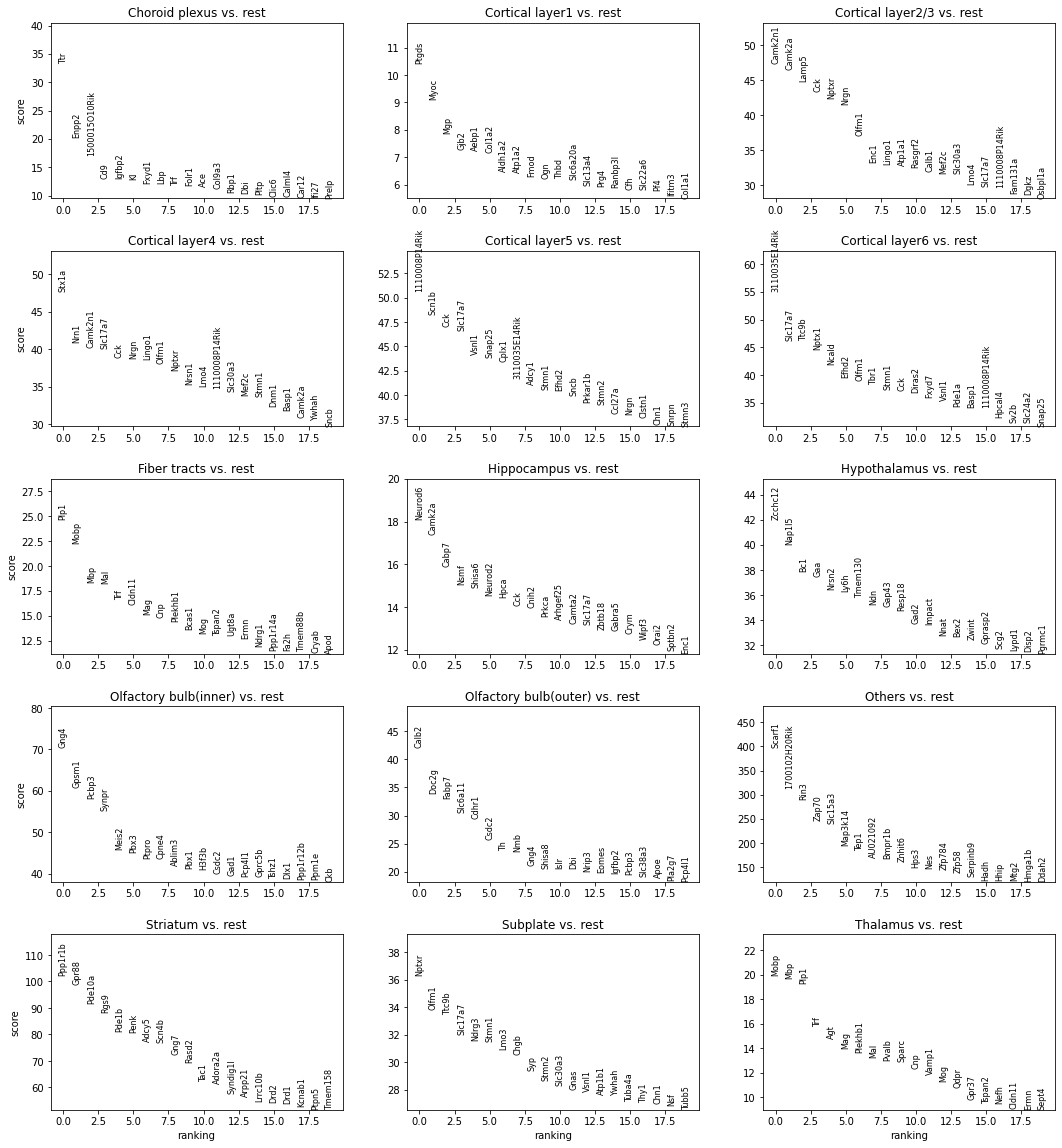

In [16]:
sc.pl.rank_genes_groups(adata, n_genes=20, ncols=3, sharey=False)

In [17]:
marker_genes = pd.DataFrame(adata.uns['rank_genes_groups']['names']).iloc[:10,:]
marker_genes

,Choroid plexus,Cortical layer1,Cortical layer2/3,Cortical layer4,Cortical layer5,Cortical layer6,Fiber tracts,Hippocampus,Hypothalamus,Olfactory bulb(inner),Olfactory bulb(outer),Others,Striatum,Subplate,Thalamus
0,Ttr,Ptgds,Camk2n1,Stx1a,1110008P14Rik,3110035E14Rik,Plp1,Neurod6,Zcchc12,Gng4,Calb2,Scarf1,Ppp1r1b,Nptxr,Mobp
1,Enpp2,Myoc,Camk2a,Nrn1,Scn1b,Slc17a7,Mobp,Camk2a,Nap1l5,Gpsm1,Doc2g,1700102H20Rik,Gpr88,Olfm1,Mbp
2,1500015O10Rik,Mgp,Lamp5,Camk2n1,Cck,Ttc9b,Mbp,Cabp7,Bc1,Pcbp3,Fabp7,Rin3,Pde10a,Ttc9b,Plp1
3,Cd9,Gjb2,Cck,Slc17a7,Slc17a7,Nptx1,Mal,Nsmf,Gaa,Synpr,Slc6a11,Zap70,Rgs9,Slc17a7,Trf
4,Igfbp2,Aebp1,Nptxr,Cck,Vsnl1,Ncald,Trf,Shisa6,Nrsn2,Meis2,Cdhr1,Slc15a3,Pde1b,Ndrg3,Agt
5,Kl,Col1a2,Nrgn,Nrgn,Snap25,Efhd2,Cldn11,Neurod2,Ly6h,Pbx3,Csdc2,Map3k14,Penk,Stmn1,Mag
6,Fxyd1,Aldh1a2,Olfm1,Lingo1,Cplx1,Olfm1,Mag,Hpca,Tmem130,Ptpro,Th,Tep1,Adcy5,Lmo3,Plekhb1
7,Lbp,Atp1a2,Enc1,Olfm1,3110035E14Rik,Tbr1,Cnp,Cck,Ndn,Cpne4,Nmb,AU021092,Scn4b,Chgb,Mal
8,Trf,Fmod,Lingo1,Nptxr,Adcy1,Stmn1,Plekhb1,Cnih2,Gap43,Ablim3,Gng4,Bmpr1b,Gng7,Syp,Pvalb
9,Folr1,Ogn,Atp1a1,Nrsn1,Stmn1,Cck,Bcas1,Prkca,Resp18,Pbx1,Shisa8,Znhit6,Rasd2,Stmn2,Sparc


Now, we focus on a specific cell type, here Striatum for demonstration.

We visualize the expression levels of the first-ranked DE gene of Striatum in UMAP space.

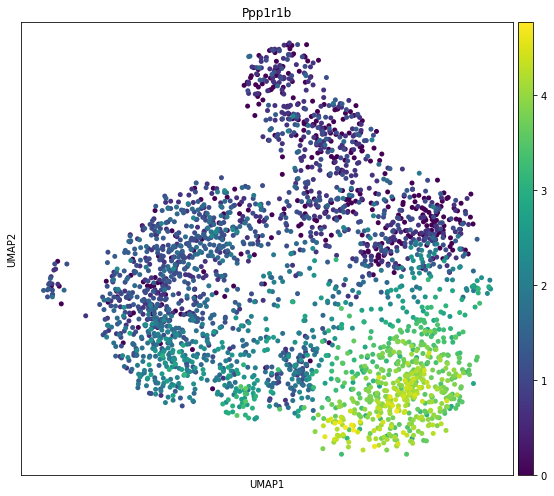

In [18]:
fig, axs = plt.subplots(figsize=(8, 7))

sc.pl.umap(
    adata,
    color=marker_genes.iloc[0,12],
    size=100,
    palette=sc.pl.palettes.default_20,
    legend_loc='right margin',
    show=False,
    ax=axs,
)

plt.tight_layout()

We also visualize the expression levels of the first-ranked DE gene of Striatum in spatial coordinates.

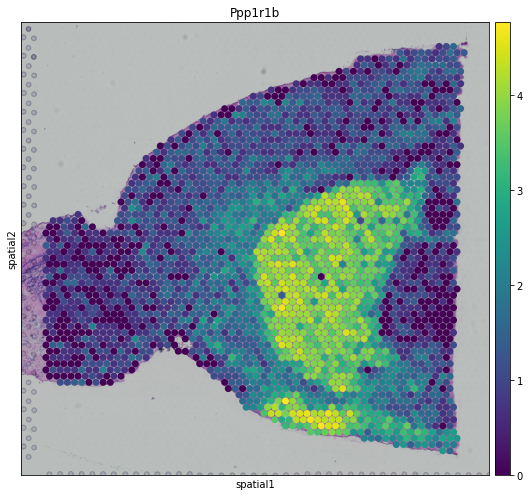

In [19]:
fig, axs = plt.subplots(figsize=(8, 7))

sc.pl.spatial(
    adata,
    img_key='hires',
    color=marker_genes.iloc[0,12],
    size=1.5,
    palette=sc.pl.palettes.default_20,
    legend_loc='right margin',
    show=False,
    ax=axs,
)

plt.tight_layout()

Then, we scale the data and visualize the expression pattern of top 3 DE genes of each cell type.

In [20]:
sc.pp.scale(adata)

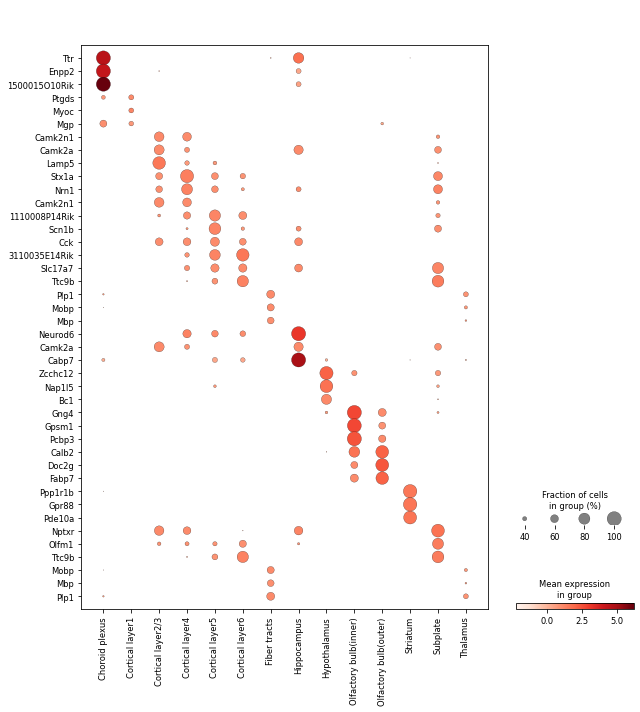

In [21]:
fig, axs = plt.subplots(figsize=(9, 10))

sc.pl.dotplot(
    adata[adata.obs['celltype'] != 'Others', :],
    var_names=marker_genes.drop('Others', axis=1).iloc[0:3, :].to_numpy().T.reshape(-1),
    groupby='celltype',
    expression_cutoff=1,
    dot_min=0.25,
    swap_axes=True,
    show=False,
    ax=axs,
)

plt.tight_layout()